# Kernel-based Time-varying Regression - Part I

In view of the needs of the address problems in our time-series modeling such as:

1. time-varying regression coefficients 
2. complex seasonality pattern

We propose a different style of solution utilizing **kernel-based regression** (**KTR**). The details of model structure and the initial idea based on an application in marketing data science can be found in Ng, Wang and Dai (2021) where the paper names this method as "Bayesian-Time-Varying Coefficients" (BTVC) Model.  The core idea is that we introduce latent variables along with their own time-point location to approximate the coefficient curves varied along time. These latent variables can also be deemded as knots in spline regression described in Hastie (1990) and Wood (2006).  Such approach sharply reduces parameters size comparing to typical dynamic linear model such as Harvey (1989) and Durbin and Koopman (2002). Hence, it improves computation speed and able to handle larger number of regressors and detect relatively smaller variance as explained in Ng (2021).

Here in **Part I**, we will cover

1. KTR model structure
2. syntax to initialize, fit and predict a model
3. fit a model with complex seasonality
4. visualization of prediction and decomposed components

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_electricity_demand

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)

1.0.16dev


## Model Structure

Our goal is to derive an additive form such that 

$$y_t = l_t + s_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the seasonality term.

In our approach, we can re-write the formula as 

$$y_t = X_t^T\beta_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $\beta_t$ is a $P$-dimensional vector of coefficients vary over time,  $X_t$ is a $P$-dimensional covariate, and $\epsilon_t$ is a stationary random error process.

Here we introduce the idea of expressing $\beta$ as such

$$\beta=Kb^T$$

where

- *knot matrix* $b$ with size $P\times J$  where each entry is a latent vairable  $b_{p, j}$ can be viewed as the "knots" from the perspective of spline regression and
$j$ is a time index such that $t_j \in [1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times J$ where the $i$th row and $j$th element can be viewed as the noramlied weight $k(t_j, t) / \sum_{j=1}^{J} k(t_j, t)$

For the level/trend,

$$l_t = \beta_{t, \text{lev}}$$

It can also be viewed as a dynamic intercept (where the regressor is a vector of ones).

For the seasonality,

$$\beta_{\text{seas}} = K_{\text{seas}}b^T_{\text{seas}}$$

$$s_t = X_{t, \text{seas}}\beta_{t, \text{seas}}$$



We use Fourier series to handle the seasonality such that seasonality terms can be expressed in a matrix $X_{t, \text{seas}}$.

There are different choices of kernel function (which determines the kernel matrix $K$) and prior for matrix $b$. We don't discuss the details here. 

## Data

To illustrate the usage of KTRLite, we use the daily series of electricity demand in Turkey from year 2000 to year 2008. It is good to model the dual seasonality (weekly and yearly), since it's a daily series.

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
df[response_col] = np.log(df[response_col])
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

Split the data into training set and test set.

In [6]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## A Quick Start on KTR

Similar to other model types in Orbit, it follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods. Note that unlike version `<=1.0.15`, we make the fitting API arg within the function. So we can just call `KTR` directly. 

In [7]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=2021,
    estimator='pyro-svi',
    # if you want a uncertainties
    n_bootstrap_draws=1e4,
)

In [8]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


We can take a look how the level is fitted with the data. 

In [9]:
predicted_df = ktr.predict(df=df)
predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2000-01-01,9.29397,9.46759,9.63597
1,2000-01-02,9.37121,9.51413,9.65346
2,2000-01-03,9.43195,9.56361,9.69585
3,2000-01-04,9.43287,9.56395,9.69444
4,2000-01-05,9.43145,9.56365,9.69552


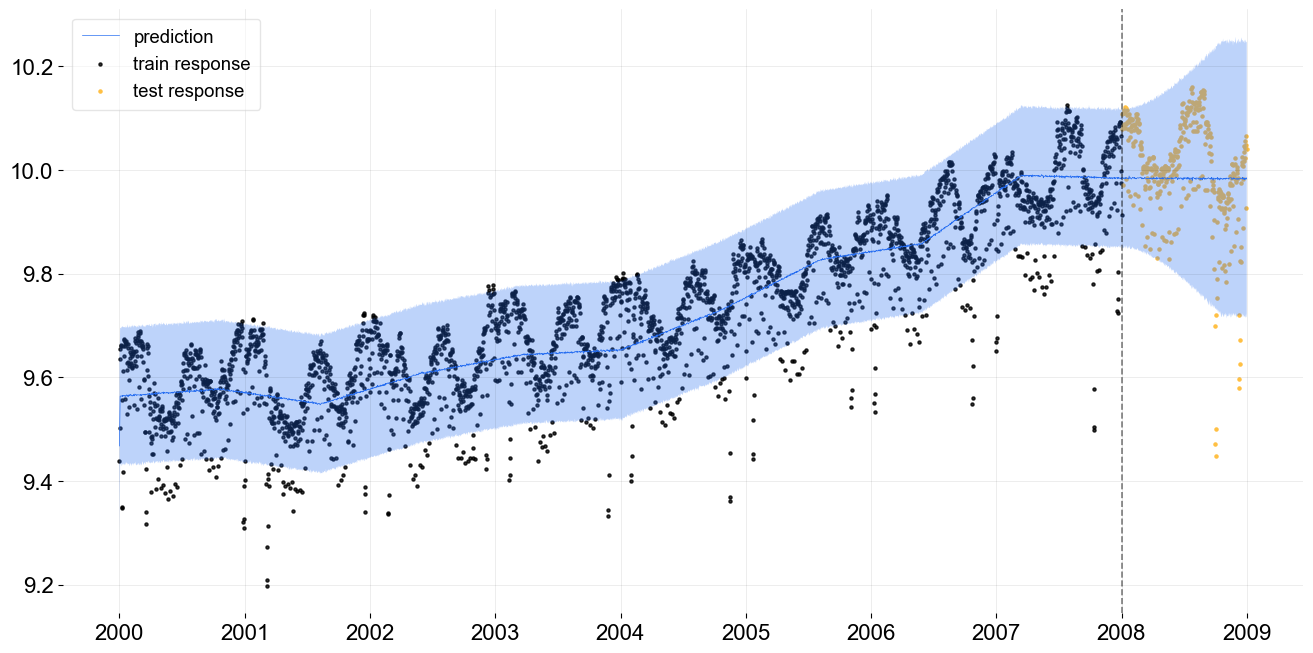

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

## Fitting with Complex Seasonality

Obviously, we should not be satisfied with the fitting here since the pattern obviously demonstrate seasonality. Here we can fit a dual seasonality for weekly and yearly pattern. Since this is daily data, we can specify the seasonality as a list of $7$ and $365.25$ to achive the dual seasonality.

In [11]:
ktr_with_seas = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=2021,
    level_segments=5,
    seasonality=[7, 365.25],
    estimator='pyro-svi',
    n_bootstrap_draws=1e4,
)

In [12]:
ktr_with_seas.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [13]:
predicted_df = ktr_with_seas.predict(df=df, decompose=True)

Tips: there is an additional arg `seasonality_fs_order` to control the number of orders we want to approximate the seasonality.  In general, they cannot violate the condition that $2 \times \text{fs_order} < \text{seasonality}$ since each order represents adding a pair of sine and cosine regressors.

## More Diagnostic and Visualization

Here are a few more diagnostic and visualization. We can see the fit and decompose components from the dual seasonal model.

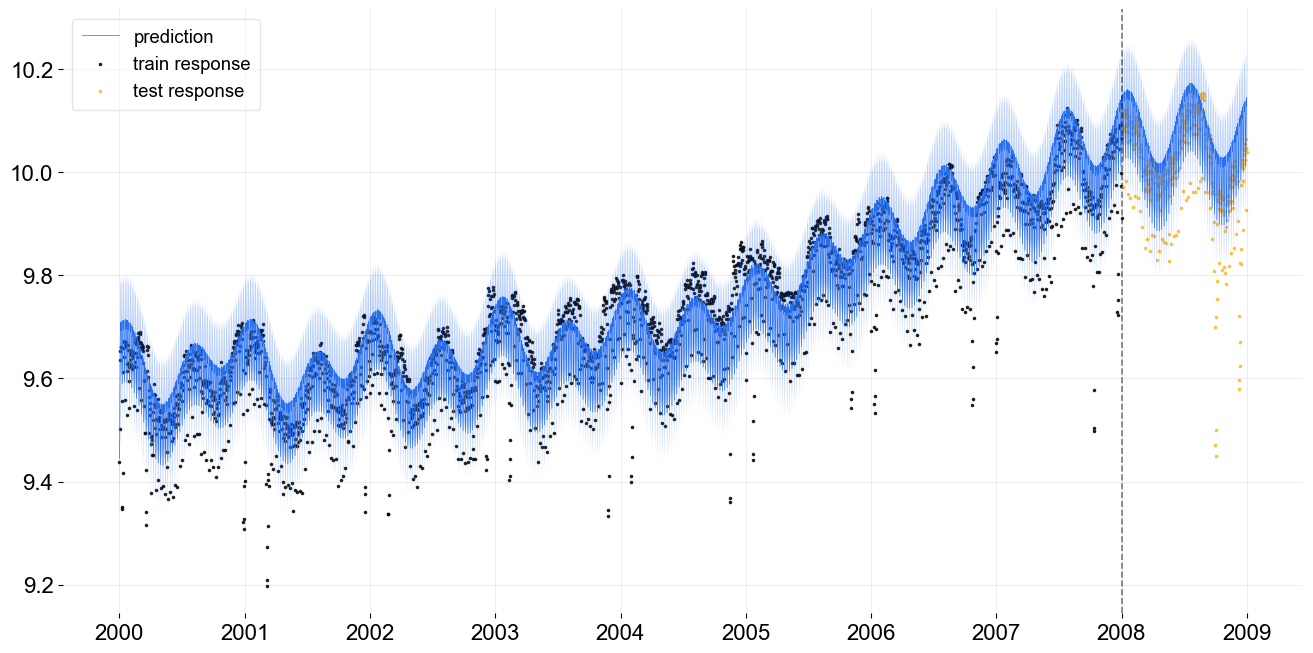

In [14]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=10, lw=.5)

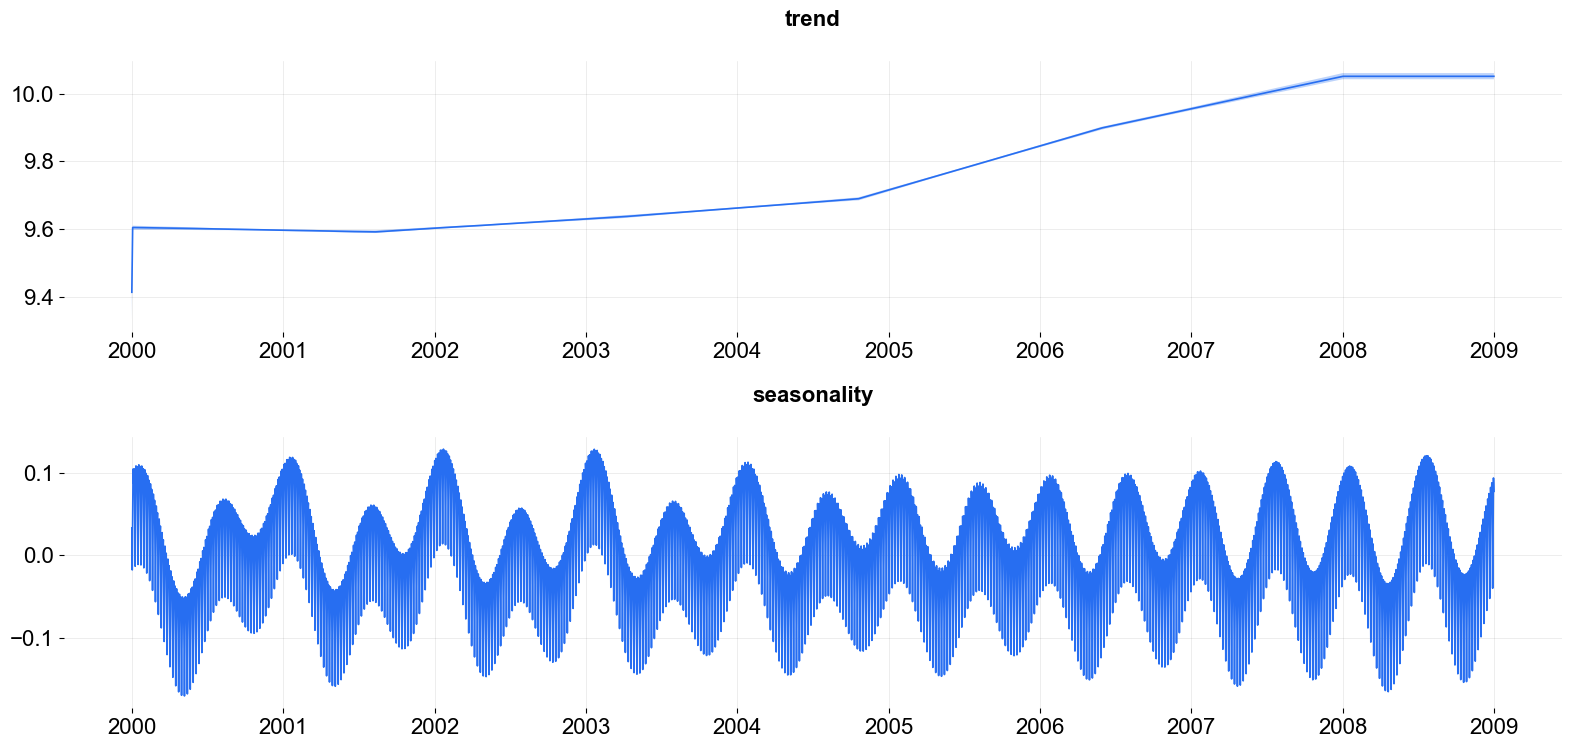

In [15]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, plot_components=['trend', 'seasonality'])

We can also use`plot_lev_knots` to visualize the knot and levels fitted.

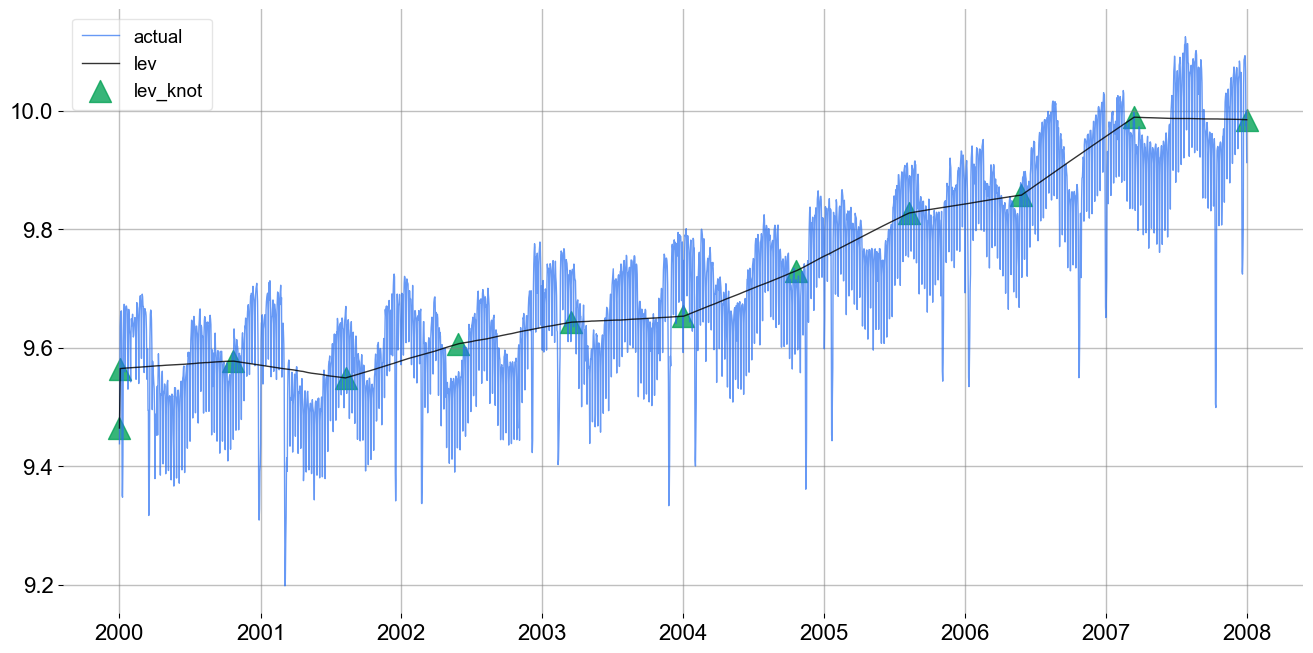

In [16]:
_ = ktr.plot_lev_knots()

## References

1. Ng, Wang and Dai (2021) Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 
2. Hastie, Trevor and Tibshirani, Robert. (1990), Generalized Additive Models, New York: Chapman and Hall.
3. Wood, S. N. (2006), Generalized Additive Models: an introduction with R, Boca Raton: Chapman & Hall/CRC
4. Harvey, C. A. (1989). Forecasting, Structural Time Series and the Kalman Filter, Cambridge University Press.
5. Durbin, J., Koopman, S. J.. (2001). Time Series Analysis by State Space Methods, Oxford Statistical Science Series